<a href="https://colab.research.google.com/github/swaingotnochill/AtlasAutoEncoder/blob/main/CERNAtlasAutoEncoder_LeakyReLU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import fastai
fastai.__version__

#Note: We are using fastai version 1.0.61

'1.0.61'

#IMPORTING DEPENDENCIES





In [ ]:
import numpy as np
import pandas as pd

from sklearn.decomposition import TruncatedSVD

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import basic_train, basic_data, train as Train
from fastai.basic_data import DatasetType


import matplotlib as mpl
import matplotlib.pyplot as plt

#DATA UPLOAD
> I am using a simple files upload here.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving monojet_Zp2000.0_DM_50.0_chan3.csv to monojet_Zp2000.0_DM_50.0_chan3.csv


#PREPROCESSING
> The data provided has delimiter (' ; '). 
> It also contains multiple jet events in one line.
> Hence we first clean and adjust data with accordance to four-momentum particles ( E, phi, eta, pt).

In [ ]:
import csv
from csv import reader
from sklearn.model_selection import train_test_split


list = []
with open('/content/monojet_Zp2000.0_DM_50.0_chan3.csv') as read_obj:
  csv_reader = reader(read_obj, delimiter = ';', skipinitialspace = True, quotechar = ',')
  for row in csv_reader:
    list.append(row)

data = []
for i in range(len(list)):
  for rows in list[i]:
    test = rows.split(',')
    if(len(test) == 5):
      data.append(test)

column_name = ['obj','E','pt','eta','phi']
dataframe = pd.DataFrame(data, columns = column_name)
dataframe_copy = dataframe.copy(deep = True)
jetData = dataframe_copy.loc[dataframe_copy['obj'] == 'j'].reset_index(drop=True)

float_column = ['E','pt','eta','phi']
for i in float_column:
  jetData[i] = jetData[i].astype(float)

dataset = jetData.drop(['obj'], axis = 1)


train, test = train_test_split(dataset, test_size = 0.2, random_state = 42)


In [79]:
#Downloading the processed data (just in case, of any use):
from IPython.display import FileLink, FileLinks

train.to_csv('/content/train.csv', index=False)

test.to_csv('/content/test.csv', index=False)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18128 entries, 1047 to 15795
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   E       18128 non-null  float64
 1   pt      18128 non-null  float64
 2   eta     18128 non-null  float64
 3   phi     18128 non-null  float64
dtypes: float64(4)
memory usage: 708.1 KB


In [ ]:
train.describe()

,E,pt,eta,phi
count,1.812800e+04,1.812800e+04,18128.000000,18128.000000
mean,4.355335e+05,2.417419e+05,0.014890,-0.013126
std,4.279418e+05,2.657371e+05,1.499743,1.810871
min,2.437580e+04,2.208650e+04,-4.870110,-3.141560
25%,1.176178e+05,4.760157e+04,-0.951571,-1.588512
50%,2.927205e+05,1.227590e+05,0.011900,-0.004561
75%,6.254612e+05,3.653140e+05,0.984084,1.534535
max,4.413680e+06,2.073990e+06,4.753080,3.141210


#NORMALIZATION
> Making the inputs having a mean of 0 and a standard deviation of 1. This makes the data scaled fixes the outliers in the data and makes the learning process much easier, smoother, and faster for the computer.

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler

train_mean = train.mean()
train_std = train.std()

train_data = (train - train_mean) / train_std
test_data = (test - train_mean) / train_std

train_x = train_data
test_x = test_data

# this is to check whether how close encoder data is compared to decoder data
train_y = train_x
test_y = test_x

#Singlar Value Decomposition
Singular value decomposition (SVD) is a mathematical process (basically matrix operations) to factorize a matrix into a lower dimension of our choice. SVD basically decomposes our matrix into 3 smaller matrices. One of them contains the singular values of the original matrix. I also tried concatenating different combinations of those 3 matrices with the original data but only singular values worked better than every other combination. 


So what we will do is we will first construct a (4 x 4) diagonal matrix from those 4 variables (Those 4 numbers will sit on the diagonal positions of the matrix). And we will feed that matrix to express that matrix in 3 components (3 because we want to compress our variables into 3). That will return us 3 matrices. But using only the singular values(data from only one matrix, which is only 3 numbers, the diagonal elements of that matrix) turned out to be performing the best for me.

In [ ]:
svd = TruncatedSVD(n_components=3)

def add_singular_values(df1):

    df_svd= df1.copy() # make a copy of the data
    sing_vals = []

    # compute and append the singular values into list sing_vals for each data entry
    for i in range(len(df_svd)):
        a = np.diag(df_svd.iloc[i])
        svd.fit(a)
        sing_vals.append(svd.singular_values_)

    # add the singular values into DataFrame
    for i in range(3):
        df_svd.insert(len(df_svd.columns), f'sv_{i}', np.array(sing_vals)[:,i])

    return df_svd



In [ ]:
train_df = add_singular_values(train_x)
test_df = add_singular_values(test_x)

> Note when I run train_df.shape, it has 7 features. Now, you might think we are increasing the features rather than decreasing. This is because we are adding singular values to our dataframe. But, when we feed this into our deep AutoEncoder, it will improve the architecture much more.

In [ ]:
train_df.shape

(18128, 7)

#DATA VISUALIZATION

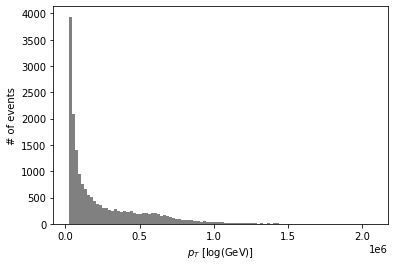

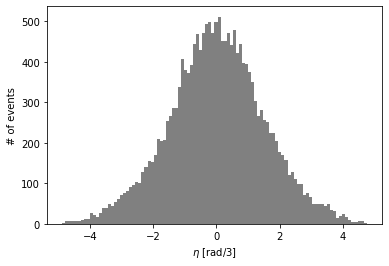

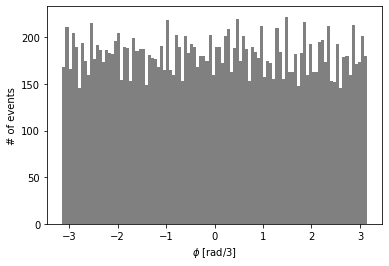

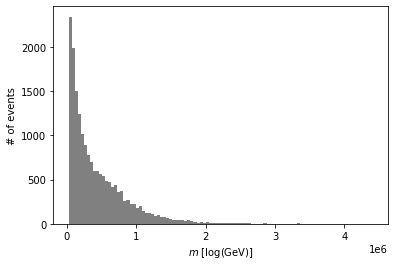

In [ ]:
import matplotlib.pyplot as plt

unit_list = ['[log(GeV)]', '[rad/3]', '[rad/3]', '[log(GeV)]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']

branches=["pt","eta","phi","E"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + ' ' + unit_list[kk])
    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

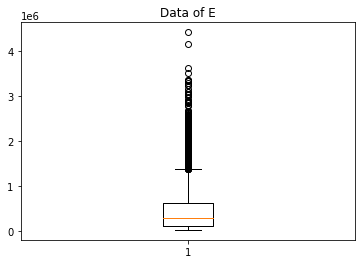

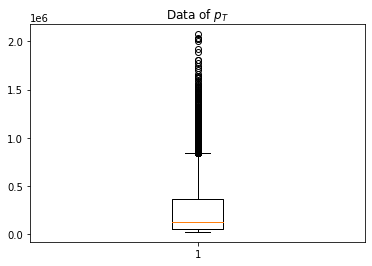

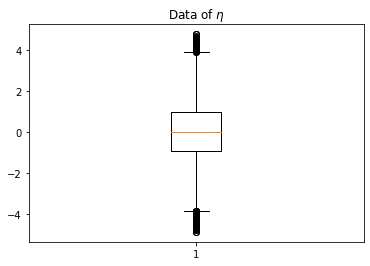

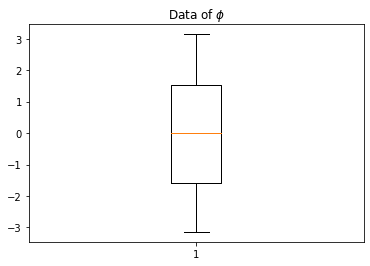

In [ ]:
variable_list = ['E',r'$p_T$', r'$\eta$', r'$\phi$']
branches=["E","pt","eta","phi"]

for kk in range(0,4):
    n_boxplot_data = plt.boxplot(train[branches[kk]])
    plt.title("Data of "+variable_list[kk])
    plt.show()
    

#PREPARATION OF DATABUNCH

---
> We need to convert dataframe object into tensor and then prepare a databunch for further training. 
> NOTE: Here, instead of creating a train, validation and test set, I used the test set as validation set, so we can have more data to train, thus improve the efficiency of model. 

I earlier tried creating 3 different set, but in the final model didn't create a test set to have more data. Eventually, when the supervisor checks, they can try with fresh test data and the residual loss will be very less. 

In [ ]:
train_ds = TensorDataset(torch.tensor(train_df.values).float(), torch.tensor(train_y.values).float())
valid_ds = TensorDataset(torch.tensor(test_df.values).float(), torch.tensor(test_y.values).float())
bs = 256 # batch size

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2, num_workers=3, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
databunch = basic_data.DataBunch(train_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#MODEL DEFINITION
The model used is non-linear by introducing tanh() activation function between layers. 
>It is 7 layer network for both encoder and decoder. 
> The Model description is as follows: 'in-200-200-20-3-20-200-200-out'


NOTE: We should not use very deep neural networks as more layers means more weights associated. Hence, when we reconstruct, residual loss will be more. 

>I also tried a different model with a linear, batchnorm and tanh activation layer, but the given model worked much better compared to that one. 



In [ ]:
#Model LeakyReLU
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=3):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(7, 200)          #We used SVD, hence it is 7 instead of 4
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, 4)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-20-3-20-200-200-out'

#model = AE_3D_200_LeakyReLU().double()
model = AE_3D_200_LeakyReLU()
model.to('cpu')

AE_3D_200_LeakyReLU(
  (en1): Linear(in_features=7, out_features=200, bias=True)
  (en2): Linear(in_features=200, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=20, bias=True)
  (en4): Linear(in_features=20, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=20, bias=True)
  (de2): Linear(in_features=20, out_features=200, bias=True)
  (de3): Linear(in_features=200, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=4, bias=True)
  (tanh): Tanh()
)

#TRAINING

This step refers to finally training the model and fine-tuning the parameters to get the best out of the model.
I used the Cyclical Learning Rates (CLR) approach. This method lets the learning rate cyclically vary between reasonable boundaries, in order to optimize the training.


In [ ]:
learner = basic_train.Learner
learn = Learner(databunch,AE_3D_200_LeakyReLU() , loss_func=nn.MSELoss(), bn_wd=False, true_wd=True)

In [ ]:
from fastai.metrics import mse
loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
#true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

learn = Learner(databunch, model=model, wd=wd, loss_func=loss_func)

#was: learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [ ]:
Train.lr_find(learn)

epoch,train_loss,valid_loss,time
0,0.758944,#na#,00:00


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


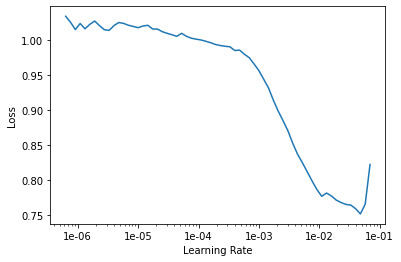

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(150, 1e-3, wd=1e-6)

epoch,train_loss,valid_loss,time
0,0.943410,0.876114,00:00
1,0.724258,0.544263,00:00
2,0.468481,0.316495,00:00
3,0.278394,0.166047,00:00
4,0.177505,0.132326,00:00
5,0.136653,0.112645,00:00
6,0.111185,0.094250,00:00
7,0.093576,0.080458,00:00
8,0.080061,0.071563,00:00
9,0.072129,0.063540,00:00


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


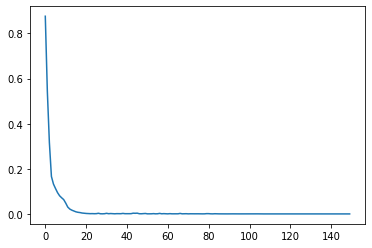

In [ ]:
plt.plot(learn.recorder.val_losses)

 We can clearly see the model does not overfit.

In [ ]:
learn.save("AE_GivenNetworkWithSVD_v1")

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


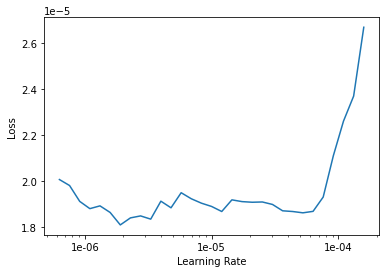

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(30, 1e-6)

epoch,train_loss,valid_loss,time
0,0.000020,0.000028,00:00
1,0.000020,0.000028,00:00
2,0.000020,0.000028,00:00
3,0.000020,0.000028,00:00
4,0.000020,0.000028,00:00
5,0.000019,0.000028,00:00
6,0.000020,0.000028,00:00
7,0.000019,0.000028,00:00
8,0.000020,0.000028,00:00
9,0.000019,0.000028,00:00


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


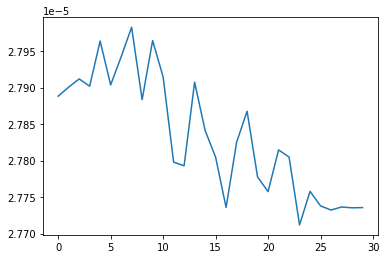

In [ ]:
plt.plot(learn.recorder.val_losses)

Although, the validation loss here might look like its fluctuating, but if you notice clearly the range of values is in order 10 ^ -5, which is very very less.

In [ ]:
learn.save("AE_GivenNetworkWithSVD_v2")

Validation Loss : 0.000028

# RECONSTRUCTION and COMPARISON

In [ ]:
import os
save_dir = "plotOutput"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

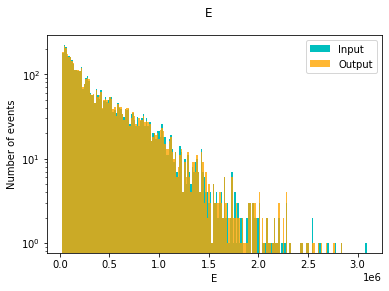

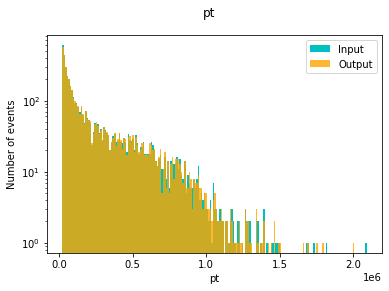

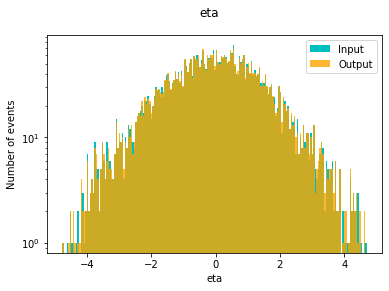

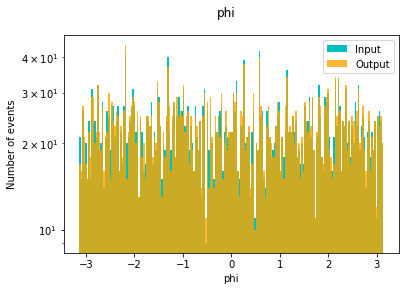

In [ ]:
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD()

plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

model.to('cpu')

save = True# Option to save figure

idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)
data_input = add_singular_values(test_x)
data_input= torch.tensor(data_input.values).float()

pred = model(data_input).detach().numpy()
# data = pipeline.inverse_transform(data)
# pred = pipeline.inverse_transform(pred)
pred = np.multiply(pred, train_std.values)
pred = np.add(pred, train_mean.values)
data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values) 
reconstructed_data = data
reconstructed_pred = pred
    
alph = 0.8
n_bins = 200
for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test.columns[kk])
    plt.xlabel(test.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test.columns[kk]+'.png'))
    plt.legend()

In [ ]:
def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins   

rat = getRatio(n_hist_data,n_hist_pred)
print(rat)

[-0.19047619047619047, 0.06666666666666667, 0.038461538461538464, 0.23529411764705882, -0.15, 0.0, -0.08333333333333333, 0.2, -0.06451612903225806, 0.20833333333333334, -0.16666666666666666, 0.047619047619047616, 0.0, 0.15789473684210525, -0.05, -0.03571428571428571, 0.14285714285714285, 0.0, -0.15384615384615385, 0.2, -0.21052631578947367, 0.037037037037037035, -0.1111111111111111, 0.09523809523809523, 0.08333333333333333, -0.07407407407407407, 0.0, 0.045454545454545456, 0.058823529411764705, -0.037037037037037035, 0.07317073170731707, -0.25, 0.047619047619047616, 0.041666666666666664, 0.0, -0.06451612903225806, 0.037037037037037035, -0.09090909090909091, 0.13043478260869565, 0.0, 0.041666666666666664, -0.18181818181818182, 0.25, -0.11764705882352941, 0.0, 0.041666666666666664, 0.0, -0.10714285714285714, 0.058823529411764705, -0.045454545454545456, 0.05263157894736842, 0.06451612903225806, -0.034482758620689655, 0.0, -0.13333333333333333, 0.1, -0.05263157894736842, 0.04166666666666666

#RESIDUAL LOSS
 
It is ratio of change in  reconstructed/decompressed data and original data to original data. 

In [ ]:
#Plot the reconstruction loss
def residual(data, pred):
    
    residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                            r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                            r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                            r'$(E_{out} - E_{in}) / E_{in}$']
    residuals = (pred - data.detach().numpy()) / data.detach().numpy() #Calculating the reconstruction loss
    print(residuals) 
  

In [ ]:
Residual = residual(reconstructed_data, reconstructed_pred)

[[ 1.684543e-02  6.609663e-04 -1.870755e-03  1.177066e-07]
 [-9.285829e-04  2.728535e-03  1.504100e-03 -6.906487e-04]
 [-2.930898e-03  3.139515e-04  9.989522e-04  1.240818e-02]
 [ 1.503171e-02 -1.056260e-02 -1.954353e-03 -2.820105e-04]
 ...
 [ 3.943562e-03  1.662492e-03  1.302612e-03 -4.680209e-04]
 [-1.427452e-03 -1.597289e-03 -3.337200e-03  7.714584e-04]
 [ 1.709704e-03 -1.269804e-02  2.123075e-03  1.765892e-03]
 [ 2.675278e-03 -4.337196e-04 -7.891554e-02 -4.195840e-04]]


In [ ]:
reconstructed_data_mean = reconstructed_data.mean()
reconstructed_pred_mean = reconstructed_pred.mean()
avg_residual = (reconstructed_pred_mean - reconstructed_data_mean)/reconstructed_data_mean
print(avg_residual)
#0.0004

tensor(2.9843e-05, dtype=torch.float64)


The Residual Loss : 2.9843 e-05

#CONCLUSION
We successfully compressed 4 momentum jet particles to 3 particles, using data processing and deep autoencoder with a validation loss of 0.000028 and residual loss of 2.9843 e-05